In [1]:
import h5py
import time
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from network.loss import *
from network.quickNAT import quick_nat
from preprocessing.data_utils import  *
from scipy import ndimage
from sklearn.model_selection import train_test_split

### Load Data

In [2]:
train_filepath = 'dataset/WholeBodyImdb/SilverCorpusDataset_CTce_10cls_Axial.mat'
test_filepath = 'dataset/WholeBodyImdb/VisceralDataset_CTce_10cls_Axial.mat'

In [3]:
# load dataset
train_data, train_labels = read_dataset(filepath=train_filepath, file_for="train")
train_data = train_data.reshape(train_data.shape[0], train_data.shape[2], train_data.shape[3], train_data.shape[1])

In [4]:
# use limited data
train_data = train_data[150:550]
train_labels = train_labels[150:550]

In [5]:
# preprocessing data
label_liver_spleen= split_dataset(train_labels, dataset="liver_spleen")
train_data, label_liver_spleen = remove_back_pixels((train_data), label_liver_spleen)

In [6]:
# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(train_data, label_liver_spleen, test_size=0.3, random_state=42)

In [7]:
X_test.shape

(33, 256, 256, 1)

### Train 

In [8]:
# config
num_classes = 3
epochs = 30
batch_size = 4
n_train = X_train.shape[0]
n_valid = X_test.shape[0]
train_total_batch = int(n_train / batch_size)  # 8077 is total number of training samples
val_total_batch = int(n_valid / batch_size)  # 3552 is total number of val samples
train_logs_path = "logs/train"
val_logs_path = "logs/val"
learning = 0.0001
momentum = 0.9
nestrov = True
ckdir = "saved_models_liver_spleen/model.ckpt"
config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)  # GPU Configuration


In [9]:
global_index = 0
list_index = 0
len_entries = 0


In [10]:
def train(restore=False, testing=False):
    # log directory of graphs
    current_time = time.strftime("%m/%d/%H/%M/%S")
    train_logdir = os.path.join(train_logs_path, "train_deep_sdnet", current_time)
    test_logdir = os.path.join(val_logs_path, "test_deep_sdnet", current_time)

    # train_dataset
    X = tf.placeholder(tf.float32, shape=[None, 192, 192, 1], name="X")
    y = tf.placeholder(tf.float32, shape=[None, 192, 192, 3], name="y")

    mode = tf.placeholder(tf.bool, name="mode")
    pred1 = quick_nat(X, mode, 3)
    tf.add_to_collection("inputs", X)
    tf.add_to_collection("inputs", mode)
    tf.add_to_collection("outputs", pred1)

    pred_prob = tf.nn.softmax(pred1, 3)

    with tf.name_scope('loss'):
        # Build loss
        loss_op_1 = weighted_cross_entropy_plus_dice(pred1, y, )
        # -dice_coef_weighted_(pred1, y)
        loss_op_1 = tf.Print(loss_op_1, [loss_op_1], message="Loss step1: ")
        tf.summary.scalar("Loss", loss_op_1)

    with tf.name_scope('loss_background'):
        # Build loss
        loss_op_back = (-dice_coef_0(pred1, y))
        tf.summary.scalar("Loss background", loss_op_back)

    with tf.name_scope('dice_loss_liver'):
        # Build loss
        loss_rlung = (-dice_coef_1(pred1, y))
        tf.summary.scalar("Loss Rlung", loss_rlung)

    with tf.name_scope('dice_loss_spleen'):
        # Build loss
        loss_llung = (-dice_coef_2(pred1, y))
        tf.summary.scalar("Loss Llung", loss_llung)

    with tf.name_scope('SGD'):
        # Gradient Descent
        train_op_1 = make_train_op(pred1, y, learning, momentum, nestrov, 3)

    with tf.name_scope('Accuracy'):
        acc = tf.equal(tf.argmax(y, 3), tf.argmax(pred1, 3))
        acc = tf.reduce_mean(tf.cast(acc, tf.float32))
        accuracy = tf.Print(acc, [acc], message="accuracy: ")
        tf.summary.scalar('Accuracy', acc)

    with tf.name_scope('Dice_Coefficient_Background'):
        # Dice Coefficient
        dice_coef_back = dice_coef_0(pred_prob, y)
        dice_coef_back = tf.Print(dice_coef_back, [dice_coef_back], message="Dice_coef_background: ")
        tf.summary.scalar('Dice Coefficient back', dice_coef_back)

    with tf.name_scope('Dice_Coefficient_Liver'):
        # Accuracy
        dice_coef_liver = dice_coef_1(pred_prob, y)
        dice_coef_liver = tf.Print(dice_coef_liver, [dice_coef_liver], message="Dice_Coefficient_Liver: ")
        tf.summary.scalar('Dice_coef_liver', dice_coef_liver)

    with tf.name_scope('Dice_Coefficient_Spleen'):
        # Accuracy
        dice_coef_spleen = dice_coef_2(pred_prob, y)
        dice_coef_spleen = tf.Print(dice_coef_spleen, [dice_coef_spleen], message="Dice_Coefficient_Spleen: ")
        tf.summary.scalar('Dice_Coefficient_Spleen', dice_coef_spleen)

    liver_prediction = tf.reshape(tf.cast(tf.argmax(pred1, axis=3), tf.float32), shape=[batch_size, 192, 192, 1])
    ground_truth = tf.reshape(tf.cast(tf.argmax(y, axis=3), tf.float32), shape=[batch_size, 192, 192, 1])

    TP = tf.count_nonzero(liver_prediction * ground_truth, dtype=tf.float32)
    TN = tf.count_nonzero((liver_prediction - 1) * (ground_truth - 1), dtype=tf.float32)
    FP = tf.count_nonzero(liver_prediction * (ground_truth - 1), dtype=tf.float32)
    FN = tf.count_nonzero((liver_prediction - 1) * ground_truth, dtype=tf.float32)

    with tf.name_scope('precision'):
        precision = TP / (TP + FP)
        tf.Print(precision, [precision], message="Precision: ")

    with tf.name_scope('recall'):
        recall = TP / (TP + FN)
        tf.Print(recall, [recall], message="Recall: ")

    with tf.name_scope('FPR'):
        fallout = FP / (FP + TN)
        tf.summary.scalar('False Positive Rate', fallout)

    with tf.name_scope('F1_score'):
        f1_score = (2 * (precision * recall)) / (precision + recall)
        tf.summary.scalar('F1 score', f1_score)

    tf.summary.image("Ground Truth", ground_truth, max_outputs=3)
    tf.summary.image("Predicted Image", liver_prediction, max_outputs=3)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state("./saved_models_liver_spleen")
    summary_op = tf.summary.merge_all()
    init = tf.global_variables_initializer()

    with tf.Session(config=config) as sess:
        # create log writer object
        train_summary_writer = tf.summary.FileWriter(train_logdir, graph=sess.graph)
        test_summary_writer = tf.summary.FileWriter(test_logdir)
        global_step = tf.train.get_global_step(sess.graph)
        sess.run(init)

        for epoch in range(epochs):
            print(epoch, "/", epochs)
            step_count_train = int(n_train / batch_size)
            for i in range(step_count_train):
                X_batch_op, y_batch_op = data_generator(batch_size, X_train, y_train,num_classes,test_data= True).__next__()
                print("-----------training---------------")
                print("epoch ", epoch, " step ", i, "/", step_count_train)

                _, step_loss_1, step_summary, global_step_value = sess.run(
                    [train_op_1, loss_op_1, summary_op, global_step],
                    feed_dict={X: X_batch_op,
                               y: y_batch_op,
                               mode: True})
                # write log
                train_summary_writer.add_summary(step_summary, (epoch))
                if (i + 1) % 5 == 0:
                    saver.save(sess, ckdir, global_step=(i + 1))
                    print("Model saved in file: %s" % ckdir)

            step_count_valid = int(n_valid / batch_size)

            for i in range(step_count_valid):
                X_valid_op, y_valid_op = data_generator(batch_size, X_test, y_test,num_classes,test_data=True).__next__()
                print("-----------validation-------------")
                print("epoch ", epoch)
                print(i, "/", step_count_valid)
                _, step_loss_1, step_summary = sess.run(
                    [train_op_1, loss_op_1, summary_op],
                    feed_dict={X: X_valid_op,
                               y: y_valid_op,
                               mode: False})
                test_summary_writer.add_summary(step_summary, (epoch))


        train_summary_writer.close()
        test_summary_writer.close()

train()

INFO:tensorflow:Summary name Loss background is illegal; using Loss_background instead.
INFO:tensorflow:Summary name Loss Rlung is illegal; using Loss_Rlung instead.
INFO:tensorflow:Summary name Loss Llung is illegal; using Loss_Llung instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Summary name Dice Coefficient back is illegal; using Dice_Coefficient_back instead.
INFO:tensorflow:Summary name False Positive Rate is illegal; using False_Positive_Rate instead.
INFO:tensorflow:Summary name F1 score is illegal; using F1_score instead.
INFO:tensorflow:Summary name Ground Truth is illegal; using Ground_Truth instead.
INFO:tensorflow:Summary name Predicted Image is illegal; using Predicted_Image instead.
0 / 30
-----------training---------------
epoch  0  step  0 / 19
-----------training---------------
epoch  0  step  1 / 19
-

-----------training---------------
epoch  4  step  6 / 19
-----------training---------------
epoch  4  step  7 / 19
-----------training---------------
epoch  4  step  8 / 19
-----------training---------------
epoch  4  step  9 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  4  step  10 / 19
-----------training---------------
epoch  4  step  11 / 19
-----------training---------------
epoch  4  step  12 / 19
-----------training---------------
epoch  4  step  13 / 19
-----------training---------------
epoch  4  step  14 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  4  step  15 / 19
-----------training---------------
epoch  4  step  16 / 19
-----------training---------------
epoch  4  step  17 / 19
-----------training---------------
epoch  4  step  18 / 19
-----------validation-------------
epoch  4
0 / 8
-----------validation-------------
epoch  4
1 / 8
-----------validation

-----------training---------------
epoch  9  step  3 / 19
-----------training---------------
epoch  9  step  4 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  9  step  5 / 19
-----------training---------------
epoch  9  step  6 / 19
-----------training---------------
epoch  9  step  7 / 19
-----------training---------------
epoch  9  step  8 / 19
-----------training---------------
epoch  9  step  9 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  9  step  10 / 19
-----------training---------------
epoch  9  step  11 / 19
-----------training---------------
epoch  9  step  12 / 19
-----------training---------------
epoch  9  step  13 / 19
-----------training---------------
epoch  9  step  14 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  9  step  15 / 19
-----------training---------------
epoch  9  step  16 / 19
-------

-----------validation-------------
epoch  13
5 / 8
-----------validation-------------
epoch  13
6 / 8
-----------validation-------------
epoch  13
7 / 8
14 / 30
-----------training---------------
epoch  14  step  0 / 19
-----------training---------------
epoch  14  step  1 / 19
-----------training---------------
epoch  14  step  2 / 19
-----------training---------------
epoch  14  step  3 / 19
-----------training---------------
epoch  14  step  4 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  14  step  5 / 19
-----------training---------------
epoch  14  step  6 / 19
-----------training---------------
epoch  14  step  7 / 19
-----------training---------------
epoch  14  step  8 / 19
-----------training---------------
epoch  14  step  9 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  14  step  10 / 19
-----------training---------------
epoch  14  step  11 / 19
-----------tr

-----------training---------------
epoch  18  step  17 / 19
-----------training---------------
epoch  18  step  18 / 19
-----------validation-------------
epoch  18
0 / 8
-----------validation-------------
epoch  18
1 / 8
-----------validation-------------
epoch  18
2 / 8
-----------validation-------------
epoch  18
3 / 8
-----------validation-------------
epoch  18
4 / 8
-----------validation-------------
epoch  18
5 / 8
-----------validation-------------
epoch  18
6 / 8
-----------validation-------------
epoch  18
7 / 8
19 / 30
-----------training---------------
epoch  19  step  0 / 19
-----------training---------------
epoch  19  step  1 / 19
-----------training---------------
epoch  19  step  2 / 19
-----------training---------------
epoch  19  step  3 / 19
-----------training---------------
epoch  19  step  4 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  19  step  5 / 19
-----------training---------------
epoch  19  step  

-----------training---------------
epoch  23  step  12 / 19
-----------training---------------
epoch  23  step  13 / 19
-----------training---------------
epoch  23  step  14 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  23  step  15 / 19
-----------training---------------
epoch  23  step  16 / 19
-----------training---------------
epoch  23  step  17 / 19
-----------training---------------
epoch  23  step  18 / 19
-----------validation-------------
epoch  23
0 / 8
-----------validation-------------
epoch  23
1 / 8
-----------validation-------------
epoch  23
2 / 8
-----------validation-------------
epoch  23
3 / 8
-----------validation-------------
epoch  23
4 / 8
-----------validation-------------
epoch  23
5 / 8
-----------validation-------------
epoch  23
6 / 8
-----------validation-------------
epoch  23
7 / 8
24 / 30
-----------training---------------
epoch  24  step  0 / 19
-----------training---------------
epoch  24  s

-----------training---------------
epoch  28  step  7 / 19
-----------training---------------
epoch  28  step  8 / 19
-----------training---------------
epoch  28  step  9 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  28  step  10 / 19
-----------training---------------
epoch  28  step  11 / 19
-----------training---------------
epoch  28  step  12 / 19
-----------training---------------
epoch  28  step  13 / 19
-----------training---------------
epoch  28  step  14 / 19
Model saved in file: saved_models_liver_spleen/model.ckpt
-----------training---------------
epoch  28  step  15 / 19
-----------training---------------
epoch  28  step  16 / 19
-----------training---------------
epoch  28  step  17 / 19
-----------training---------------
epoch  28  step  18 / 19
-----------validation-------------
epoch  28
0 / 8
-----------validation-------------
epoch  28
1 / 8
-----------validation-------------
epoch  28
2 / 8
-----------val

### Load Test Image

In [11]:
test_data, test_labels = read_dataset(filepath=test_filepath, file_for="test")

In [12]:
test_data = test_data.reshape(test_data.shape[0], test_data.shape[2], test_data.shape[3], test_data.shape[1])

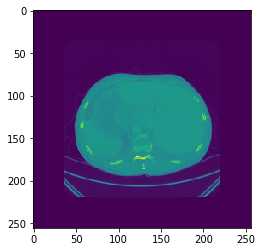

In [13]:
plt.imshow(test_data[100].reshape(256,256))

In [14]:
test_liver_spleen_original = split_dataset(test_labels, dataset="liver_spleen")

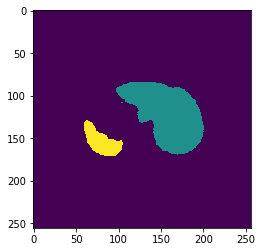

In [15]:
plt.imshow(test_liver_spleen_original[100])

### Load saved Model

In [16]:
sess = tf.Session()

In [17]:
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph("./saved_models_liver_spleen/model.ckpt-")
saver.restore(sess, tf.train.latest_checkpoint("./saved_models_liver_spleen"))
X = tf.get_collection("inputs")[0]
mode = tf.get_collection("inputs")[1]

INFO:tensorflow:Restoring parameters from ./saved_models_liver_spleen/model.ckpt-15


In [18]:
pred1 = tf.get_collection("outputs")[0]

In [19]:
test_data[100].shape

(256, 256, 1)

In [20]:
test_image = centeredCrop((test_data[100]).reshape(1,256,256,1),192,192)

In [21]:
pred = sess.run(pred1, feed_dict={X: test_image , mode: False})


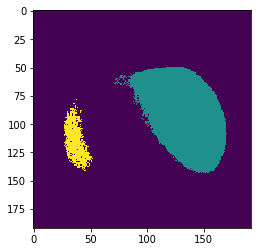

In [22]:
plt.imshow(np.argmax(pred[0],2))

In [23]:
pred_np = sess.run(tf.nn.softmax(pred))